In [6]:
import torch as th 
from pathlib import Path
import torch as th 
from models import MODEL_REGISTRY
import matplotlib.pyplot as plt 
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from utils import get_custom_dataset_loaders

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [13]:
ROOT = Path(__name__).absolute().parent 
model_path = ROOT / "trained" / "xception_tuned"

model = MODEL_REGISTRY["xception"]()
model.load_state_dict(th.load(model_path, map_location=th.device('cpu')))
model.eval()

_, testloader = get_custom_dataset_loaders(img_shape=(256, 256), device="cpu")

In [14]:
tp = []
tp_targets = []
fn = []


total = 0
correct = 0
for batch, targets in testloader:
    with th.no_grad():
        predict = model(batch)

    _, predicted = th.max(predict, 1)
    _, labels = th.max(targets, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    tp.append(batch[predicted == labels])
    tp_targets.append(predicted)
    fn.append(batch[predicted != labels])

tp = th.concat(tp)
tp_targets = th.concat(tp_targets)
fn = th.concat(fn)
correct / total

0.9932432432432432

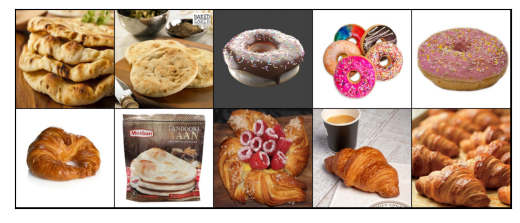

In [15]:
show(make_grid(tp[:10], 5))

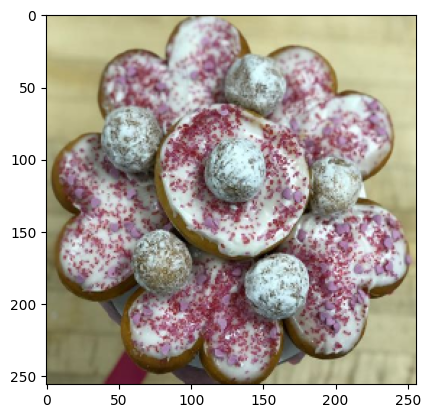

In [17]:
plt.imshow(fn.squeeze(0).permute(1, 2, 0))

In [18]:
def xception_feature_map(model, img):
    with th.no_grad():
        _, predicted = th.max(model(img), 1)
        maps = model.features(img) * model.last_linear.weight[predicted][..., None, None]
    feature_maps = th.sum(maps, 1)
    return feature_maps

feature_maps = xception_feature_map(model, tp[:10])

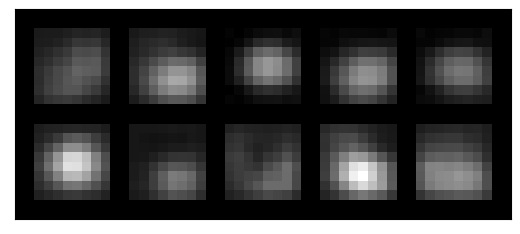

In [19]:
show(make_grid(feature_maps.unsqueeze(1), 5, normalize=True))

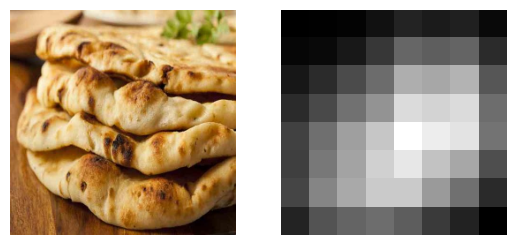

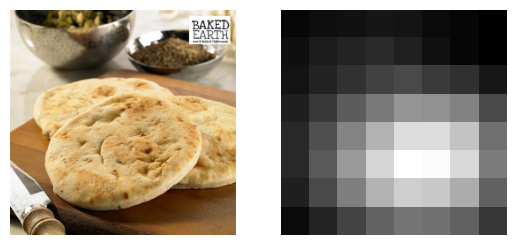

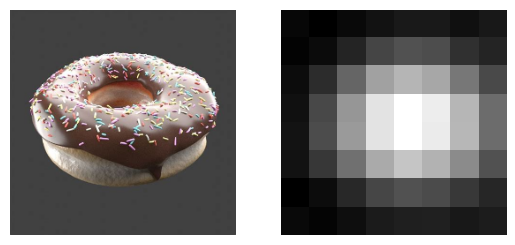

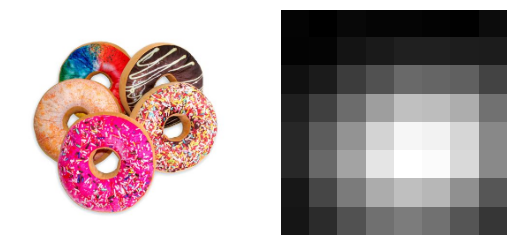

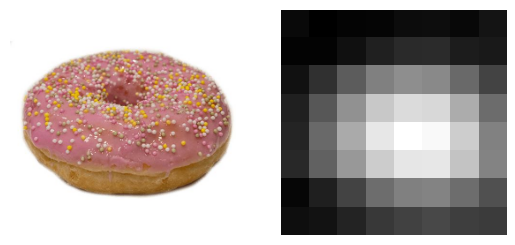

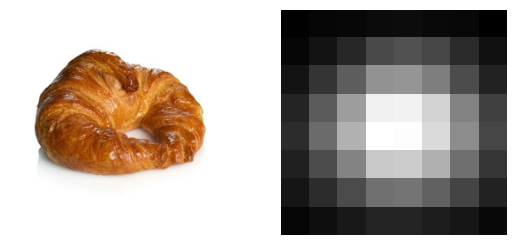

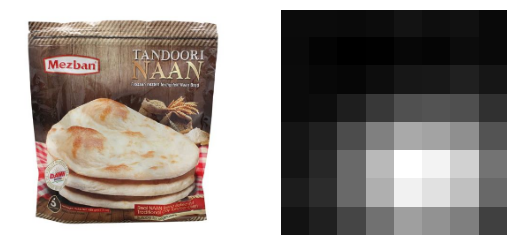

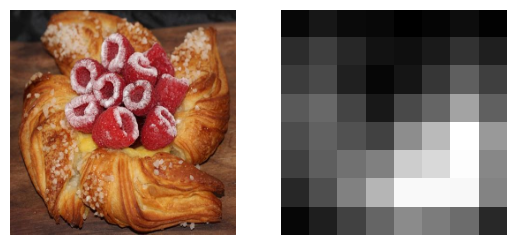

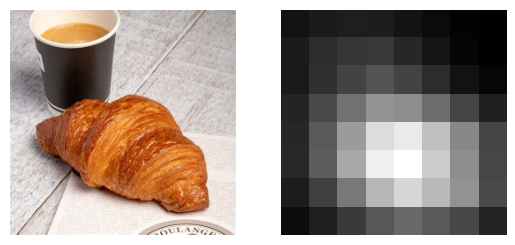

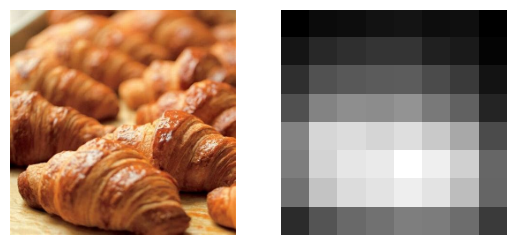

In [20]:
for i, feature in enumerate(feature_maps):
    img = th.Tensor(tp[i])
    feature = (feature - feature.min()) / (feature.max() - feature.min())
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    fig.add_subplot(1, 2, 2)
    plt.imshow(feature, cmap="gray")
    plt.axis("off")


(-0.5, 7.5, 7.5, -0.5)

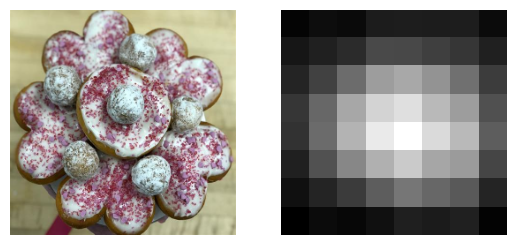

In [21]:
feature = xception_feature_map(model, fn)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(fn[0].permute(1, 2, 0))
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(feature[0], cmap="gray")
plt.axis("off")